### Illustrative notebook : The MAB-VAE

In [ ]:
!pip install pytorch-lightning
print("Please restart the runtime after installing pytorch-ligthning")

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
from collections import OrderedDict
import matplotlib.pyplot as plt
import warnings
import pytorch_lightning as pl
import h5py as h5
from pytorch_lightning import Trainer
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/MyDrive/VAE')

### In this notebook, we consider the following scenario : 

We want to construct a VAE for a particular generation problem (that could be easy or complex). We are pretty confident on the architecture of our encoder but not really for the decoder. Hence, we decide to design $K$ decoders and our goal will be to find among these decoders, which one is going to render the best result in the long term.

In order to solve the problem, I propose to use a classis multi-armed bandit strategy called the $\epsilon$ greedy-strategy. The idea is simple :

At time $t$, 

- with $\epsilon$ probability, we select a decoder randomly
- with 1-$\epsilon$ probability, we select the decoders that is known as the one having the minimum average reconstruction loss so far.

With this strategy, we could propose a certain number of decoders and see what is the one emerging after a few number of epochs.

### Importation of the datasets

Here, we are going to consider gradually complex datasets :

- The QMNIST dataset made of written numbers between 0 and 9
- The FashionMNIST dataset made of binarized clothes icons
- The CIFAR10 dataset made of RGB images of different kinds

All the images of these datasets have been resized to 32x32 to save time in the training phase.

In [7]:
transform =  transforms.Compose([transforms.Resize((32,32)),
                                 transforms.ToTensor()])

In [8]:
fashion_trainset = datasets.FashionMNIST(root='./data', train=True, download=False, transform=transform)
fashion_loader=DataLoader(fashion_trainset, batch_size=128, shuffle=True, num_workers=0)

qmnist_trainset = datasets.QMNIST(root='./data', train=True, download=False, transform=transform)
qmnist_loader=DataLoader(qmnist_trainset, batch_size=128, shuffle=True, num_workers=0)

cifar_trainset = datasets.CIFAR10(root='./data', transform=transform)
cifar_loader=DataLoader(cifar_trainset, batch_size=128, shuffle=True, num_workers=0)

torch.Size([128, 1, 32, 32])


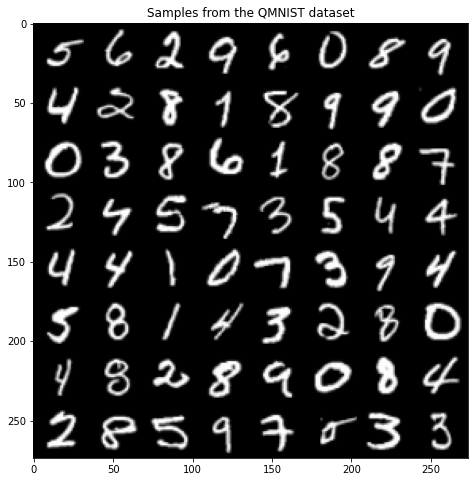

In [9]:
it=iter(qmnist_loader)
real_batch = next(iter(it))
plt.figure(figsize=(8,8))
print(real_batch[0].size())
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.title('Samples from the QMNIST dataset');

torch.Size([128, 1, 32, 32])


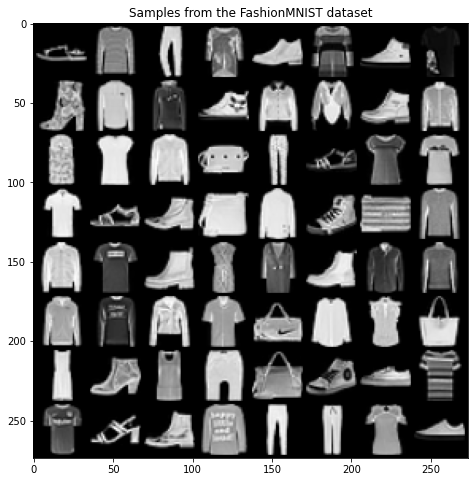

In [10]:
it=iter(fashion_loader)
real_batch = next(iter(it))
plt.figure(figsize=(8,8))
print(real_batch[0].size())
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.title('Samples from the FashionMNIST dataset');

torch.Size([128, 3, 32, 32])


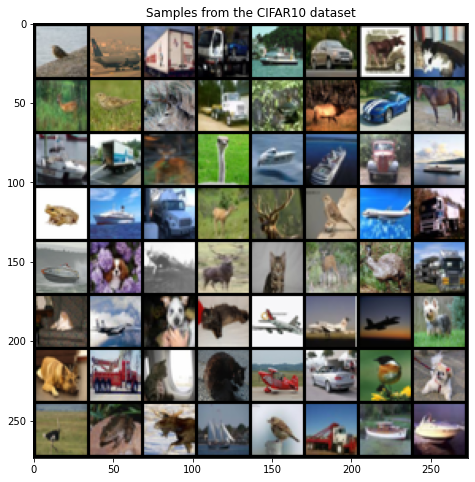

In [11]:
it=iter(cifar_loader)
real_batch = next(iter(it))
plt.figure(figsize=(8,8))
print(real_batch[0].size())
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.title('Samples from the CIFAR10 dataset');

#### MAB-VAE :

The code of the MAB-VAE is available in the library `MVAE.py` present in the repository.

Let us propose different type of decoders that we will use for the two first datasets. (We can't use exactly the same one for the last dataset because it is made of RGB images while the other images are binary).

Remark : The encoder is considered as fixed by simplicity => The latent_dim should be the same for all decoders

In [12]:
from MVAE import *

In [15]:
Decoders=nn.ModuleList([Decoder_MLP(latent_dim=100, in_channel=1, im_size=32, hiddens=[128,256,512]),
          Decoder_MLP(latent_dim=100, in_channel=1, im_size=32, hiddens=[256,512,1024]),
          Decoder_Conv(latent_dim=100, in_channel=1, im_size=32, hiddens=[1024,512,256,128],init=2),
          Decoder_Conv(latent_dim=100, in_channel=1, im_size=32, hiddens=[1024,512,256],init=4),
          Decoder_Linear_Conv(latent_dim=100, in_channel=1, im_size=32, hiddens=[512,256,128,64],init=2)])

#Creation of a MabVAE instance
MVAE = MabVAE(qmnist_loader,Decoders,eps=0.3,i=0)

**The details of the decoders architectures are in the library `MVAE.py`**

In [ ]:
#We use the GPU for making computations faster
trainer = Trainer(gpus=1,max_epochs=3)
trainer.fit(MVAE)

In [18]:
torch.save(MVAE,'MNIST.pt')

#### Now the training is ended, let's see the decoder that has been called the most often

In [27]:
MVAE.NbDraws/torch.sum(MVAE.NbDraws)

tensor([0.7244, 0.0623, 0.0586, 0.0650, 0.0897], device='cuda:0')

#### The first decoder has been the one that has been the most called so it is certainly the best option for our model. Let's see what we can obtain with a random generation of MNIST numbers.

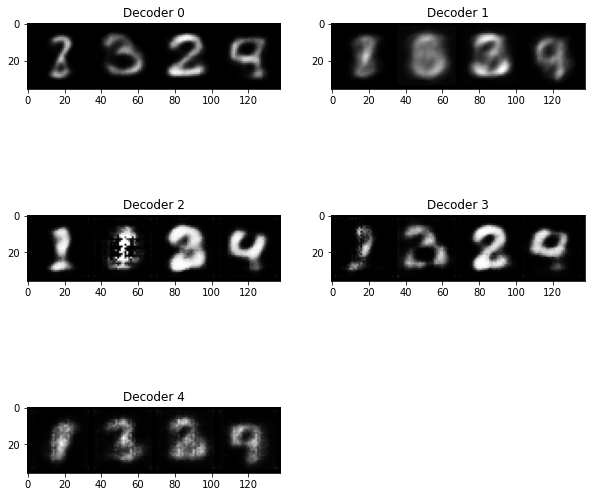

In [42]:
fixed_noise=torch.randn(4,100)
plt.figure(figsize=(10,10))
for i,decoder in enumerate(Decoders):
  fake=decoder(fixed_noise).detach()
  plt.subplot(3,2,i+1)
  plt.title(f'Decoder {i}')
  plt.imshow(np.transpose(utils.make_grid(fake,padding=2,normalize=True).cpu(),(1,2,0)))

plt.savefig(f'Decoders_MNIST.png')

#### Indeed, the best reconstruction is obtained with the first decoder. That could seems surprising since the encoding was made with convolutional layers. Hence we could have expected that the best decoders will be the ones using deconvolutions. Knowing that, we could advice to someone which wants to generate MNIST numbers to use a MLP decoder.

#### We can also plot the pseudo-regret of our algorithm to see its performance through the time. Here i simply defined it as :

$$R(t) = \sum_{\tau=1}^{t} (RL_{D_{\tau}}^*-RL_{D_{\tau}})$$ where $RL_{D_{\tau}}^*$ is the best decoder to choose at time $\tau$ and $RL_{D_{\tau}}$ is the decoder chosen by our strategy at time $\tau$.

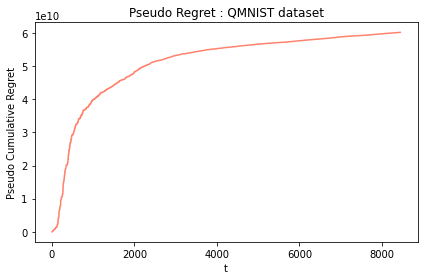

In [46]:
Regrets=[]
for i in range(len(MVAE.strategy_path)):
  #best strategy at time t - strategy chosen by the algorithm
  Regrets.append(MVAE.strategy_path[i]-MVAE.best_rewards[i])

Regrets=torch.Tensor(Regrets)
Regrets=Regrets.view(-1)

I=torch.arange(1,MVAE.t,1)
R=torch.cumsum(Regrets,dim=0)
plt.plot(I,R,color='tomato',alpha=0.8)
plt.title('Pseudo Regret : QMNIST dataset')
plt.xlabel('t')
plt.ylabel('Pseudo Cumulative Regret')
plt.savefig('Regret_Mnist.png')
plt.tight_layout();

#### We observe a sublinear pseudo regret so it's rather satisfying.

Let's see now what we could obtain from the MAB-VAE on the Fashion MNIST dataset !

In [ ]:
Decoders=nn.ModuleList([Decoder_MLP(latent_dim=100, in_channel=1, im_size=32, hiddens=[128,256,512]),
          Decoder_MLP(latent_dim=100, in_channel=1, im_size=32, hiddens=[256,512,1024]),
          Decoder_Conv(latent_dim=100, in_channel=1, im_size=32, hiddens=[1024,512,256,128],init=2),
          Decoder_Conv(latent_dim=100, in_channel=1, im_size=32, hiddens=[1024,512,256],init=4),
          Decoder_Linear_Conv(latent_dim=100, in_channel=1, im_size=32, hiddens=[512,256,128,64],init=2)])

MVAE = MabVAE(fashion_loader,Decoders,eps=0.3,i=0)

trainer = Trainer(gpus=1,max_epochs=3)
trainer.fit(MVAE)

In [48]:
torch.save(MVAE,"FashionMNIST.pt")

#### Now the training is ended, let's see  again the decoder that has been called the most often

In [49]:
MVAE.NbDraws/torch.sum(MVAE.NbDraws)

tensor([0.0597, 0.0576, 0.0598, 0.0618, 0.7611], device='cuda:0')

#### This time, it's the last decoder that has been chosen the most often ! Hence, we could already see that there is no perfect decoder enabling to solve all the problems and that justify this study.

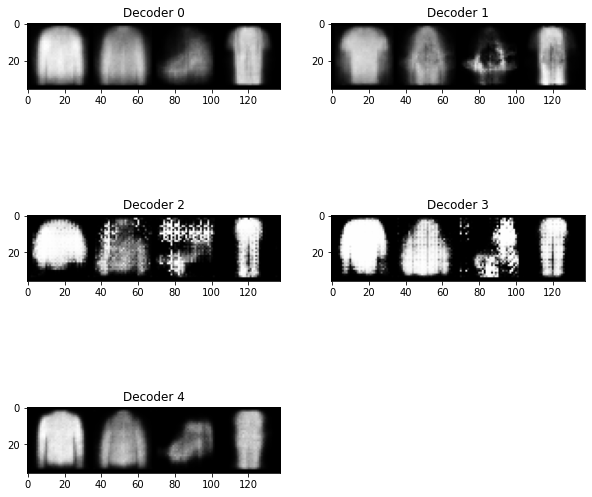

In [55]:
fixed_noise=torch.randn(4,100)
plt.figure(figsize=(10,10))
for i,decoder in enumerate(Decoders):
  fake=decoder(fixed_noise).detach()
  plt.subplot(3,2,i+1)
  plt.title(f'Decoder {i}')
  plt.imshow(np.transpose(utils.make_grid(fake,padding=2,normalize=True).cpu(),(1,2,0)))

plt.savefig(f'Decoders_FashionMNIST.png')

##### We can also plot the pseudo-regret curve like before : 

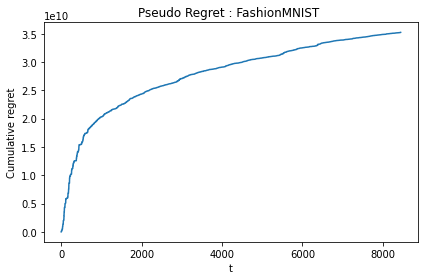

In [56]:
Regrets=[]
for i in range(len(MVAE.strategy_path)):
  Regrets.append(MVAE.strategy_path[i]-MVAE.best_rewards[i])

Regrets=torch.Tensor(Regrets)
Regrets=Regrets.view(-1)

I=torch.arange(1,MVAE.t,1)
R=torch.cumsum(Regrets,dim=0)
plt.plot(I,R)
plt.title('Pseudo Regret : FashionMNIST ')
plt.xlabel('t')
plt.ylabel('Cumulative regret')
plt.savefig('Regret_FashionMNIST.png')
plt.tight_layout();

#### We again observe a sublinear pseudo-regret, this is satisfying.

#### Now, it's time to see how our MAB-VAE will react with a more complex dataset : CIFAR10

In [ ]:
# # Init ModelCheckpoint callback, monitoring 'loss'
# checkpoint_callback = ModelCheckpoint(monitor='total_loss',mode='min')
Decoders_cifar=nn.ModuleList([Decoder_MLP(latent_dim=200, in_channel=3, im_size=32, hiddens=[128,256,512]),
          Decoder_MLP(latent_dim=200, in_channel=3, im_size=32, hiddens=[256,512,1024]),
          Decoder_Conv(latent_dim=200, in_channel=3, im_size=32, hiddens=[1024,512,256,128],init=2),
          Decoder_Conv(latent_dim=200, in_channel=3, im_size=32, hiddens=[1024,512,256],init=4),
          Decoder_Linear_Conv(latent_dim=200, in_channel=3, im_size=32, hiddens=[1024,512,256],init=4)])

MVAE = MabVAE(train_loader=cifar_loader,decoders=Decoders_cifar,eps=0.3,i=0)

trainer = Trainer(gpus=1,max_epochs=5)
trainer.fit(MVAE)

In [59]:
torch.save(MVAE,'CIFAR.pt')

In [61]:
MVAE.NbDraws/torch.sum(MVAE.NbDraws)

tensor([0.0622, 0.7592, 0.0598, 0.0609, 0.0580], device='cuda:0')

#### The arm which is the most often called is the second one. Let's see the decoding of some random latent variables to judge about the  the reconstruction quality of the different decoders.

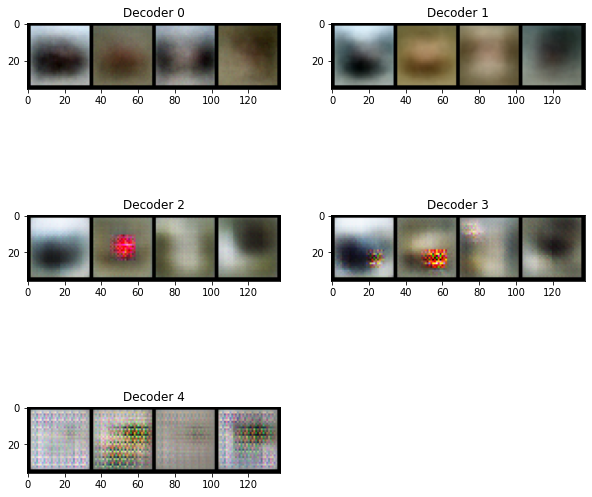

In [60]:
fixed_noise=torch.randn(8,100)
plt.figure(figsize=(10,10))
for i,decoder in enumerate(MVAE.decoders):
  fake=decoder(fixed_noise).detach()
  plt.subplot(3,2,i+1)
  plt.title(f'Decoder {i}')
  plt.imshow(np.transpose(utils.make_grid(fake,padding=2,normalize=True).cpu(),(1,2,0)))

plt.savefig(f'Decoders_CIFAR.png')

#### This time, we clearly didn't succeed in generating meaningful data. However, this was rather expected since we are not doing many epochs here and this dataset is really complex considering the wide range of images it contains. At last, we can be tempted to see the pseudo-regret curve as before.

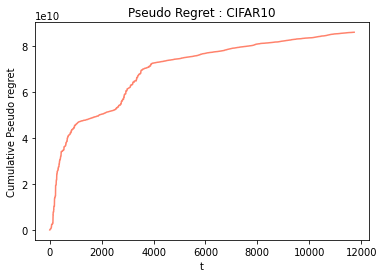

In [64]:
Regrets=[]
for i in range(len(MVAE.strategy_path)):
  Regrets.append(MVAE.strategy_path[i]-MVAE.best_rewards[i])

Regrets=torch.Tensor(Regrets)
Regrets=Regrets.view(-1)

I=torch.arange(1,MVAE.t,1)
R=torch.cumsum(Regrets,dim=0)

plt.plot(I,R,color='tomato',alpha=0.8)
plt.title('Pseudo Regret : CIFAR10')
plt.xlabel('t')
plt.ylabel('Cumulative Pseudo regret')
plt.savefig('Regret_cifar.png');

#### Like before, we observe a sublinear pseudo-regret.

##### Conclusions and perspectives :

- Through this experiment we have seen that designing a MAB problem for making the search of an appropriate decoder could reveal to be really interesting. In just a few epochs and different problems/datasets, we have clearly seen that some decoders are more appropriate than others for a particular task and that it is not really possible to guess the best one by advance. Hence, solving such a problem can potentially really help a person to save time in the search of the best decoder architecture.

- Now, we could also imagine different couples of architectures for the encoders and the decoders while varying the dimensionality of the latent space. However, doing so will apply more computations and will take some times and I recall that the aim is to save time !

- At last, it could be also a good idea to perform a Bayesian optimization for tuning the hyperparameters of a VAE such as the learning rate, the dimension of the latent size or the batch size.